# Pregunta 2

## a) Carga de datos de NORB

Carga de datos de entrenamiento. En este caso debido a limitaciones de hardware se modificó la función original para cargar un solo batch de datos NORB.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict


def load_single_NORB_train_val(PATH, i):
    print "Cargando batch training set",i,"..."
    f = os.path.join(PATH, 'data_batch_%d' % (i, ))
    datadict = unpickle(f)
    X = datadict['data'].T
    Y = np.array(datadict['labels'])
    Z = np.zeros((X.shape[0], X.shape[1] + 1))
    Z[:,:-1] = X
    Z[:, -1] = Y
    np.random.shuffle(Z)
    Xtr = Z[5832:,0:-1]
    Ytr = Z[5832:,-1]
    Xval = Z[:5832,0:-1]
    Yval = Z[:5832,-1]
    print "Cargado"
    return Xtr, Ytr, Xval, Yval


def load_NORB_test(PATH):
    print "Cargando testing set..."
    xts = []
    yts = []
    for b in range(11, 13):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        datadict = unpickle(f)
        X = datadict['data'].T
        Y = np.array(datadict['labels'])
        Z = np.zeros((X.shape[0], X.shape[1] + 1))
        Z[:,:-1] = X
        Z[:, -1] = Y
        np.random.shuffle(Z)
        xts.append(Z[0:,0:-1])
        yts.append(Z[:,-1])
    Xts = np.concatenate(xts)
    Yts = np.concatenate(yts)

    del xts,yts
    print "Cargado."
    return Xts, Yts

# Modelo MLP FF
def get_ff_model(activation, n_classes):
    model = Sequential()
    model.add(Dense(4000, input_dim=2048, activation=activation))
    model.add(Dense(2000, activation=activation))
    model.add(Dense(n_classes, activation='softmax'))
    sgd = SGD(lr=0.1, decay=0.0)
    model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


# Establecer rangos para dividir training set en escenario no supervisado
def split_train(X, Y, theta):
    # n_s es la cantidad de ejemplos que si sabemos su etiqueta
    n_s = int(theta * n_tr)
    # Dividir training set
    X_s = X[0: n_s]
    Y_s = Y[0: n_s]
    X_ns = X[n_s: ]
    return X_s, Y_s, X_ns


Using Theano backend.


### b) Función para escalar data entre rango (-1,1) o bien normalización.

In [2]:
def scale_data(X, normalize=True, myrange=None):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    if normalize and not myrange:
        print "Normalizing data (mean 0, std 1)"
        return StandardScaler().fit_transform(X)
    elif isinstance(myrange, tuple):
        print "Scaling data to range", myrange
        return X * (myrange[1] - myrange[0]) + myrange[0]
    else:
        return "Error while scaling data."

A continuación se cargará un batch del dataset y se mostrarán imágenes convertidas bajo las dos formas de escalamiento.

In [3]:
(Xtr, Ytr, Xval, Yval) = load_single_NORB_train_val(".", 1)

Cargando batch training set 1 ...
Cargado


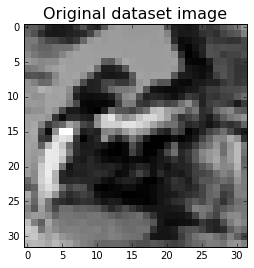

Scaling data to range (-1, 1)


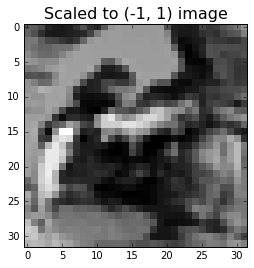

Normalizing data (mean 0, std 1)


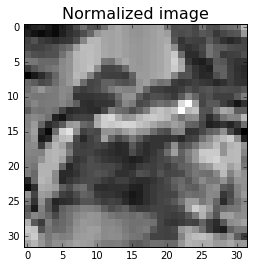

In [4]:
%matplotlib inline
img =  Xtr[25][0:1024].reshape((32,32))
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("Original dataset image", fontsize=16)
plt.show()

img_scaled_2 = scale_data(img, normalize=False, myrange=(-1,1))
plt.title("Scaled to (-1, 1) image", fontsize=16)
plt.imshow(img_scaled_2, cmap='gray', interpolation='nearest')
plt.show()

img_scaled_01 = scale_data(img, normalize=True)
plt.imshow(img_scaled_01, cmap='gray', interpolation='nearest')
plt.title("Normalized image", fontsize=16)
plt.show()

## c) Entrenamiento de Red FF variando tamaño de batches utilizados.
Como la red al ser entrenada llenaba el buffer definido por el notebook los resultados fueron ingresados manualmente a partir de los arrojados por el entrenamiento.

Min loss: 0.230461893191


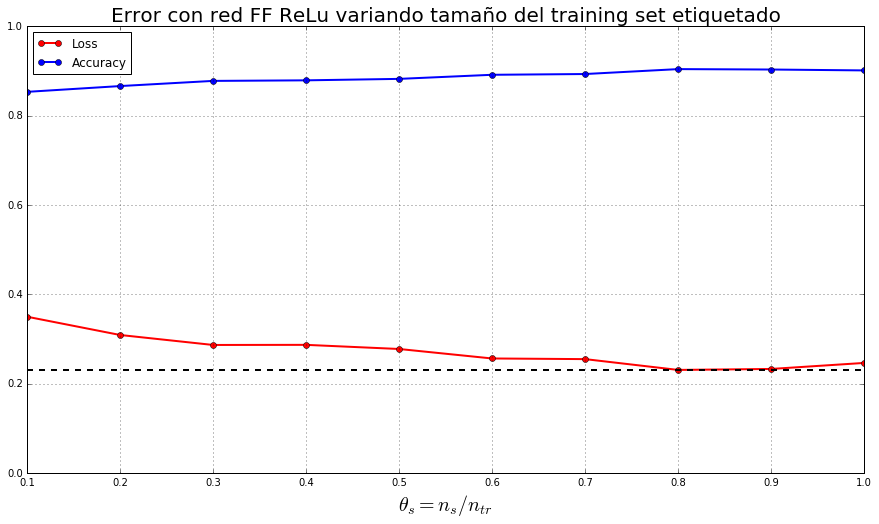

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
thetas = np.linspace(0.1, 1, 10)
plt.figure(figsize=(15,8))
ff_score = np.array([[0.34965633492870829, 0.85337219132808007], [0.30873315344310387, 0.86633515952791207], 
                  [0.28638169108870831, 0.8779120964645849], [0.28662411729384862, 0.87917810043802969], 
                  [0.27735552345804965, 0.88243598899764453], [0.25611561523247078, 0.89160094224172037], 
                  [0.25466067208978765, 0.89329561710725591], [0.23046189319056207, 0.90432671244947349], 
                  [0.23262660608841529, 0.9034007855362689], [0.24611747253683636, 0.90140890138957075]])
ff_loss = ff_score[:,0]
min_loss = np.min(loss)
print "Min loss:",min_loss
ff_accuracy = ff_score[:,1]
plt.title(u'Error con red FF ReLu variando tamaño del training set etiquetado', fontsize=20)
plt.xlabel(r'$ \theta _s = n_s/n_{tr}$', fontsize=20)
#plt.ylabel(u'Error de prueba', fontsize=20)
plt.xticks(thetas)
plt.xlim((0.1, 1))
plt.ylim((0, 1))
plt.plot(thetas, ff_loss, 'ro-', lw=2, label="Loss")
plt.plot(thetas, ff_accuracy, 'bo-', lw=2, label="Accuracy")
plt.plot([0.1, 1.0], [min_loss, min_loss], 'k--', lw=2)
plt.grid()
plt.legend(loc='best')
plt.show()

Como se ha aprendido, se observa que a medida que aumentamos la cantidad de datos la red es capaz de aprender y lograr un buen rendimiento. La línea punteada indica la menor pérdida obtenida (~ 0.204), utilizando 8 de 10 batches.

## d) Agregar pre-entrenamiento a red FF ReLu

En este caso se han utilizado Autoencoders y RBM para verificar si existen o no mejoras.

Las estrategias a seguir fueron las siguientes:

1) Utilizar exactamente la misma red FF (con 4000 unidades en la primera capa oculta y 2000 en la segunda), preentrenando con autoencoder y RBM, lo que implica aumentar la dimensionalidad original de 2048 a 4000.

2) Apostar por reduccion de dimensionalidad, forzando a reducir de 2048 a 512 tanto con autoencoders con RBM.

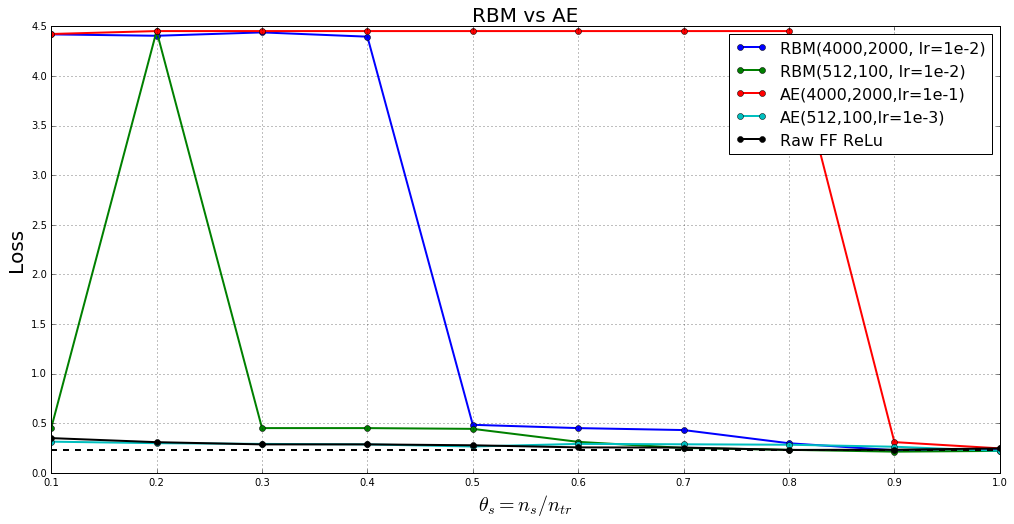

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

thetas = np.linspace(0.1, 1, 10)

plt.figure(figsize=(17,8))

# Score RBM con 4000,2000 unidades escondidas
scoreRBM = np.array([[4.4196084509047955, 0.72383116337947229], [4.4055034453445341, 0.72456847458301099],
                    [4.4394828855419028, 0.72233082052570641], [4.3964983934053672, 0.72311099884400476],
                    [0.48378892842838628, 0.83260457615262029], [0.45056016894443207, 0.83313326793115983],
                    [0.43085911105526165, 0.83389629889662864],[0.29784013472614995, 0.87206218527586532],
                    [0.22757617234340544, 0.90586420740365003], [0.24125085612158553, 0.90226624000546696]])

# Score RBM con 512,100 unidades escondidas
scoreRBM2 = np.array([[0.45062856095624559, 0.83333331346511841], [4.4528440643403426, 0.72222222402099068],
                      [0.45072658859775883, 0.83333331346511841], [0.4505750023911928, 0.83333331346511841],
                      [0.4429623542662674, 0.82581160080571892], [0.31188208550094682, 0.86670381540051866],
                      [0.25056480781516299, 0.89664495450192849], [0.23156057456198476, 0.90414952838330931],
                      [0.21324420206690148, 0.91417467884402548],[0.22067879932703877, 0.91151407051356237]])

# Score AE con 4000,2000 unidades escondidas de entrenamiento, lr=1e-1
scoreAE = np.array([[4.423457844859942, 0.72402835125295228], [4.4528440647287137, 0.72222222367350131],
                    [4.4528440647287137, 0.72222222367350131], [4.4528440647287137, 0.72222222367350131],
                    [4.4528440647287137, 0.72222222367350131], [4.4528440665888036, 0.72222222393922841],
                    [4.4528440670384954, 0.722222223775704], [4.4528440630321473, 0.72222222410275283],
                    [0.30934715830596082, 0.90771034156548469], [0.24611747253683636, 0.90140890138957075]])

# Score AE con 512,100 unidades escondidas de entrenamiento, lr=1e-3
scoreAE2 = np.array([ [0.31381310524600359, 0.87419124327814623], [0.29862671588044182, 0.88824588954653105],
                    [0.29122977651079507, 0.89595336747063203],[0.28631529953734458, 0.89848251762417941],
                    [0.26520682642347659, 0.90412380808992476],[0.29133136388273245, 0.90601852678263306],
                    [0.28742324732237945, 0.90006859361389535],[0.28288218034693235, 0.90822188775930224],
                    [0.26280671141278994, 0.91445188456315885], [0.22067879932703877, 0.91151407051356237]])

lossRBM = scoreRBM[:,0]
accuracyRBM = scoreRBM[:,1]
lossRBM2 = scoreRBM2[:,0]
accuracyRBM2 = scoreRBM2[:,1]

lossAE = scoreAE[:,0]
accuracyAE = scoreAE[:,1]
lossAE2 = scoreAE2[:,0]
accuracyAE2 = scoreAE2[:,1]

plt.title(u'RBM vs AE', fontsize=20)
plt.xlabel(r'$ \theta _s = n_s/n_{tr}$', fontsize=20)
plt.xticks(thetas)
plt.xlim((0.1, 1))
plt.plot(thetas, lossRBM, 'o-',lw=2, label="RBM(4000,2000, lr=1e-2)")
plt.plot(thetas, lossRBM2, 'o-', lw=2, label="RBM(512,100, lr=1e-2)")
plt.plot(thetas, lossAE, 'o-', lw=2, label=r"AE(4000,2000,lr=1e-1)")
plt.plot(thetas, lossAE2, 'o-', lw=2, label="AE(512,100,lr=1e-3)")
plt.plot([0.1, 1.0], [min_loss, min_loss], 'k--', lw=2)
plt.plot(thetas, ff_loss, 'ko-', lw=2, label="Raw FF ReLu")
plt.ylabel("Loss", fontsize=20)
plt.grid()
plt.legend(loc='best', fontsize=16)
plt.show()

Se puede apreciar que en general la reducción de dimensionalidad ayuda bastante en obtener buenos resultados rápidamente sobre el conjunto de pruebas. Existen no obstante inestabilidades, por ejemplo durante el entrenamiento de la red FF con RBM, que provocan peaks en la pérdida. 

Los métodos que aumentaron la dimensionalidad durante el pre entrenamiento sufrieron por mucho tiempo de, lo que se teoriza, son mínimos locales, y no fue hasta que más de la mitad del conjunto de entrenamiento se incorporó a la red FF que se logró escapar de dicha pérdida.

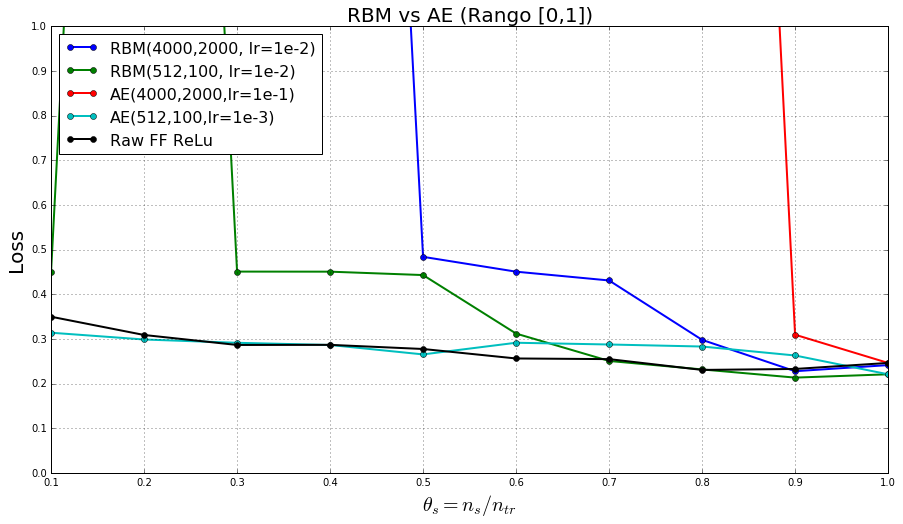

In [58]:
plt.figure(figsize=(15,8))
plt.title(u'RBM vs AE (Rango [0,1])', fontsize=20)
plt.xlabel(r'$ \theta _s = n_s/n_{tr}$', fontsize=20)
plt.xticks(thetas)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim((0.1, 1))
plt.ylim((0, 1))
plt.plot(thetas, lossRBM, 'o-',lw=2, label="RBM(4000,2000, lr=1e-2)")
plt.plot(thetas, lossRBM2, 'o-', lw=2, label="RBM(512,100, lr=1e-2)")
plt.plot(thetas, lossAE, 'o-', lw=2, label=r"AE(4000,2000,lr=1e-1)")
plt.plot(thetas, lossAE2, 'o-', lw=2, label="AE(512,100,lr=1e-3)")
plt.plot(thetas, ff_loss, 'ko-', lw=2, label="Raw FF ReLu")
#plt.plot([0.1, 1.0], [min_loss, min_loss], 'k--', lw=2)
plt.ylabel("Loss", fontsize=20)
plt.grid()
plt.legend(loc='upper left', fontsize=16)
plt.show()

En este gráfico se aprecia mejor el efecto del pre entrenamiento, donde mientras más data haya para pre entrenar, mejor score inicial se obtiene. A medida que este factor $\theta$ crece, el efecto desaparece.

## e) Análisis utilizando FF con Sigmoidales y tanh

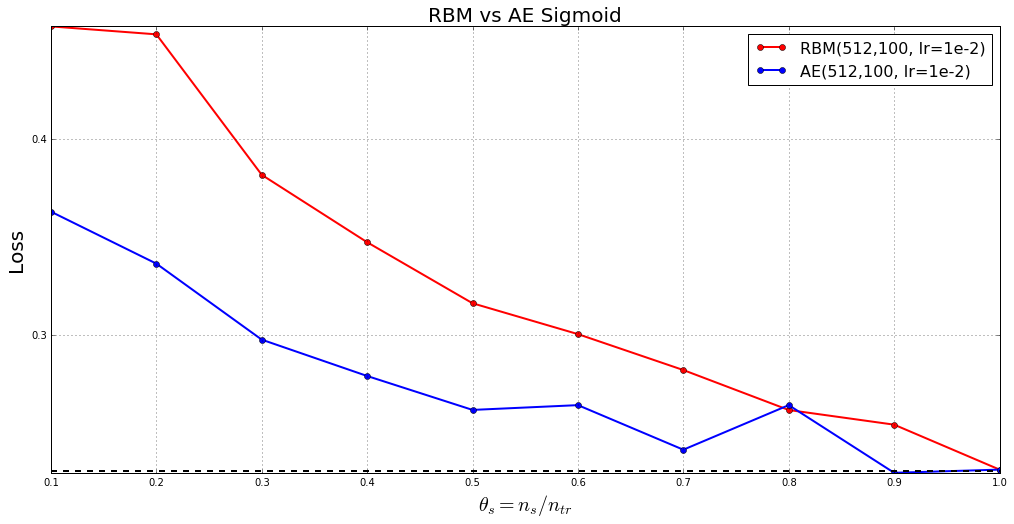

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

thetas = np.linspace(0.1, 1, 10)

plt.figure(figsize=(17,8))

score_RBM_512_sig = np.array([[0.45771518255620991, 0.83333331346511841],[0.45365564825092486, 0.83333331346511841],
                              [0.38187248474408569, 0.83758285605899263], [0.34743673724361246, 0.84777375865620352],
                              [0.31626026423083331, 0.85903920216897223], [0.30048906122716285, 0.86761259483825037], 
                              [0.28214155361235183, 0.8757115920752655], [0.26172314131113766, 0.88501657923716737], 
                              [0.25423361747608675, 0.88900034828686425], [0.23126906758322494, 0.90095736967356277]]
)

score_AE_512_sig = np.array([[0.36305900167454092, 0.84831959977030591],[0.33650884347289434, 0.85545838133665764],
                            [0.2976713113037075, 0.8675240031015562],[0.27910095958782688, 0.87922668276132376],
                            [0.26177046708864848, 0.88473937295591876], [0.26421231387402805, 0.88531093294278751],
                            [0.24143604994706799, 0.89582762480885891],[0.26421231387402805, 0.88531093294278751],
                            [0.22964162562190668, 0.90080876522716669], [0.23126906758322494, 0.90095736967356277]])

loss_RBM_512_sig = score_RBM_512_sig[:,0]
loss_AE_512_sig = score_AE_512_sig[:,0]

plt.title(u'RBM vs AE Sigmoid', fontsize=20)
plt.xlabel(r'$ \theta _s = n_s/n_{tr}$', fontsize=20)
plt.xticks(thetas)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim((0.1, 1))
plt.plot(thetas, loss_RBM_512_sig, 'ro-',lw=2, label="RBM(512,100, lr=1e-2)")
plt.plot(thetas, loss_AE_512_sig, 'bo-',lw=2, label="AE(512,100, lr=1e-2)")
#plt.plot(thetas, ff_loss, 'ko-', lw=2, label="Raw FF")
plt.plot([0.1, 1.0], [min_loss, min_loss], 'k--', lw=2)
plt.ylabel("Loss", fontsize=20)
plt.grid()
plt.legend(loc='best', fontsize=16)
plt.show()


Se puede apreciar que en general la versión pre entrenada con autoencoders funciona mejor que con RBM dados por supuesto los parámetros con los que se armaron dichas redes. No se pudo superar con pre entrenamiento el mínimo logrado con FF ReLu sin pre entrenamiento.

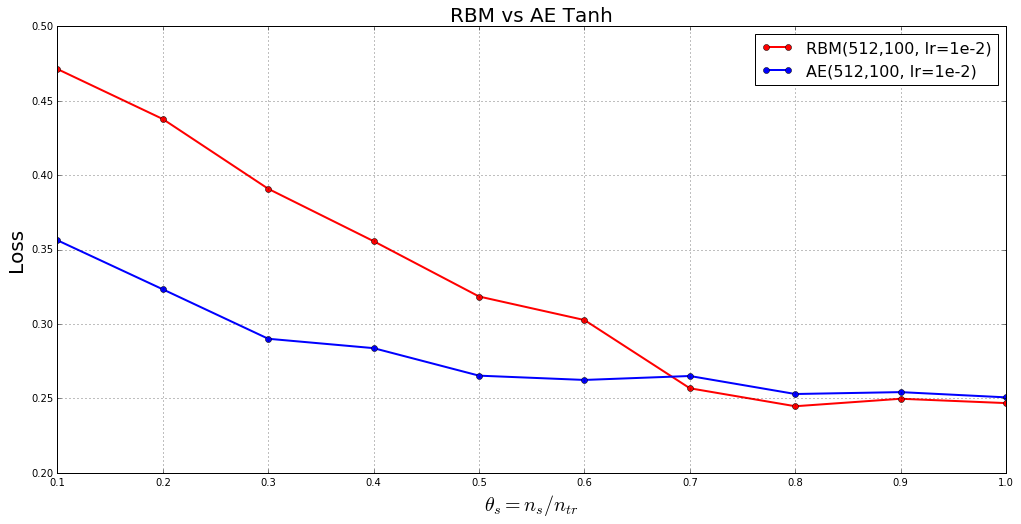

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

thetas = np.linspace(0.1, 1, 10)

plt.figure(figsize=(17,8))

score_RBM_512_tanh = np.array([[0.47132537652967071, 0.83333617125846071], [0.43773106490204361, 0.81772403969890628],
                               [0.39085262340579097, 0.83759428964434668], [0.3556465181906609, 0.84698787069942072],
                               [0.3184757399882493, 0.86379743537090115], [0.30265503884286749, 0.87056469970442796],
                               [0.25681082942537115, 0.89028635624136943], [0.2447317991679118, 0.89441301461069023],
                               [0.2497562807307557, 0.89397577249505067], [0.2468455718116086, 0.89485025849443733]])

score_AE_512_tanh = np.array([[0.35625298988631071, 0.85218620511852661], [0.32329397273744331, 0.8609053455957496],
                              [0.29008143559987409, 0.87735196781460967], [0.28377419225207245, 0.87887231570212443],
                              [0.2652835471910745, 0.88701417956332607], [0.26240534692509571, 0.88862026109780468], 
                              [0.26505667790617227, 0.88871742608166204], [0.25295013446802855, 0.89182956670046831],
                              [0.25422075993875848, 0.89163523609909667], [0.25069631986889801, 0.8929641120473053]]
)

loss_RBM_512_tanh = score_RBM_512_tanh[:,0]
loss_AE_512_tanh = score_AE_512_tanh[:,0]

plt.title(u'RBM vs AE Tanh', fontsize=20)
plt.xlabel(r'$ \theta _s = n_s/n_{tr}$', fontsize=20)
plt.xticks(thetas)
plt.xlim((0.1, 1))
plt.plot(thetas, loss_RBM_512_tanh, 'ro-',lw=2, label="RBM(512,100, lr=1e-2)")
plt.plot(thetas, loss_AE_512_tanh, 'bo-',lw=2, label="AE(512,100, lr=1e-2)")
#plt.plot(thetas, ff_loss, 'ko-', lw=2, label="Raw FF")
#plt.plot([0.1, 1.0], [min_loss, min_loss], 'k--', lw=2)
plt.ylabel("Loss", fontsize=20)
plt.grid()
plt.legend(loc='best', fontsize=16)
plt.show()


Utilizando activaciones tanh, el desempeño no es muy bueno. El pre entrenamiento al menos con estas configuraciones de redes se vuelve estable. Notar que nuevamente pre entrenamiento con red ReLu o una red ReLu por sí sola logra mejores cometidos en los experimentos.